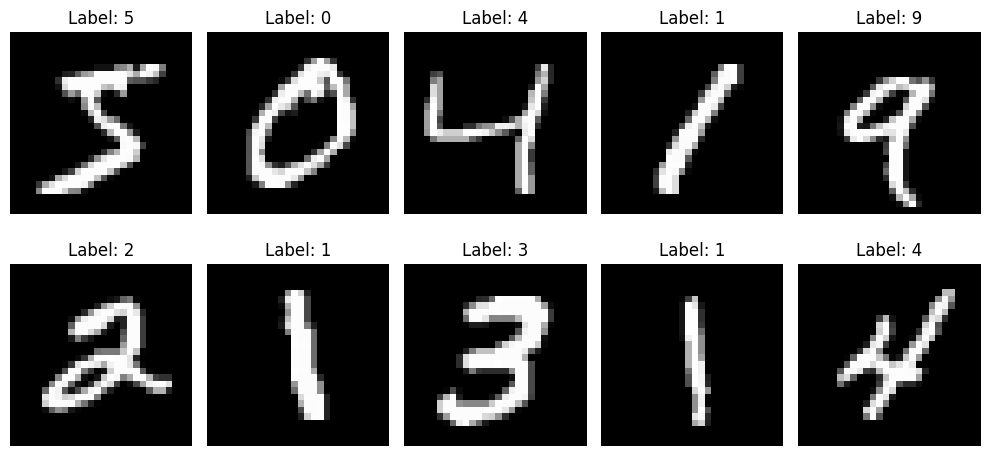

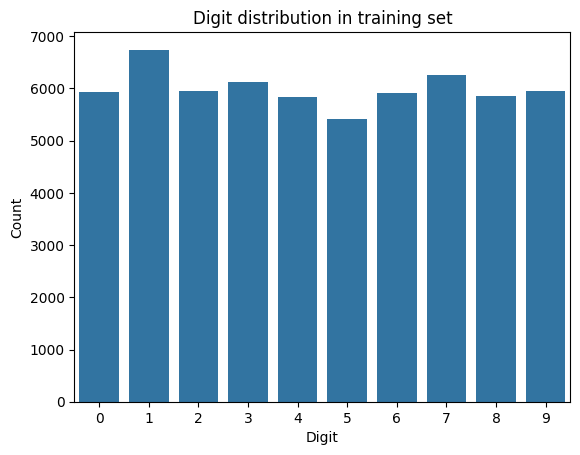

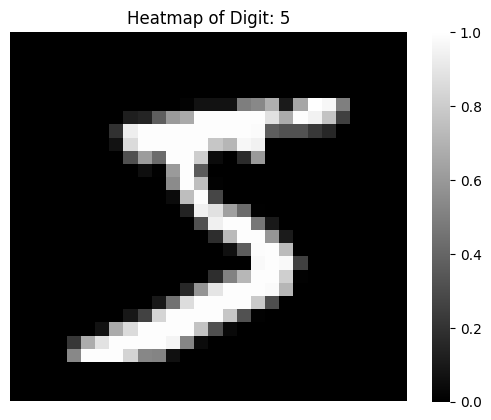

Summary: The dataset is fairly balanced. Some digits like 1 and 7 might be confused due to shape similarities.
Epoch 1 | Train Acc: 0.8807 | Val Acc: 0.9313
Epoch 2 | Train Acc: 0.9420 | Val Acc: 0.9472
Epoch 3 | Train Acc: 0.9563 | Val Acc: 0.9578
Epoch 4 | Train Acc: 0.9658 | Val Acc: 0.9632
Epoch 5 | Train Acc: 0.9728 | Val Acc: 0.9663
Epoch 6 | Train Acc: 0.9773 | Val Acc: 0.9702
Epoch 7 | Train Acc: 0.9807 | Val Acc: 0.9708
Epoch 8 | Train Acc: 0.9835 | Val Acc: 0.9723
Epoch 9 | Train Acc: 0.9861 | Val Acc: 0.9732
Epoch 10 | Train Acc: 0.9874 | Val Acc: 0.9761


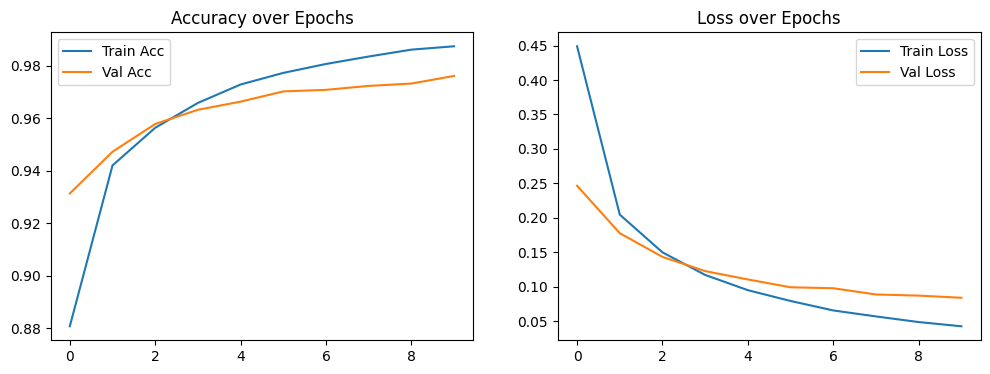

Test Accuracy: 0.9768


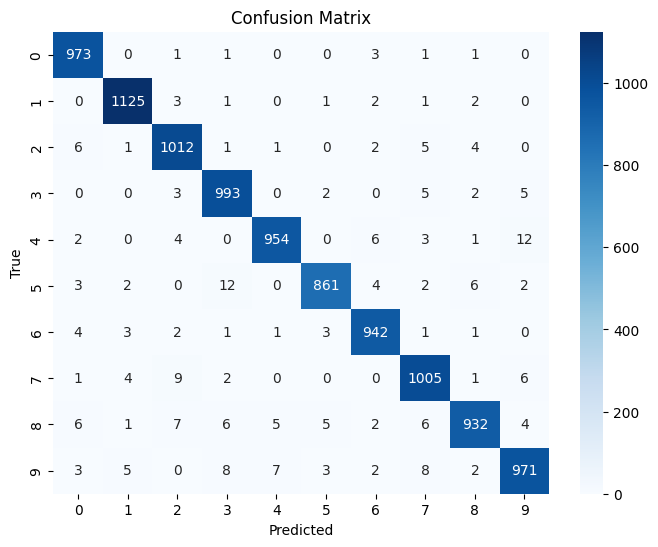

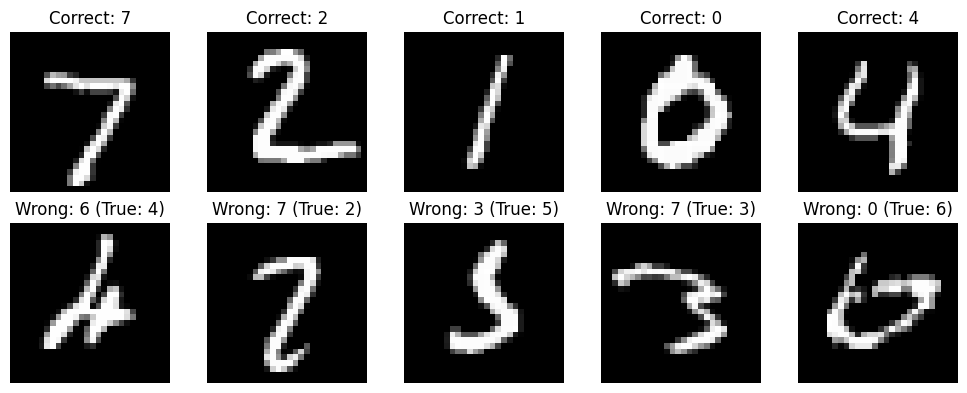

Some misclassified digits are due to faint or distorted handwriting styles, especially 4, 9, and 5.
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d6540082f9ac4a78f9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:
                ########### James Dabrowski ML Project ########################
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
!pip install gradio
import gradio as gr
from PIL import Image

# transform and load dataset
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# train/val split
train_data, val_data = random_split(train_dataset, [50000, 10000])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    image, label = train_dataset[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# digit distribution
labels = [label for _, label in train_dataset]
sns.countplot(x=labels)
plt.title("Digit distribution in training set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# heatmap of a sample digit
sample_img, sample_label = train_dataset[0]
sns.heatmap(sample_img.squeeze(), cmap='gray')
plt.title(f"Heatmap of Digit: {sample_label}")
plt.axis('off')
plt.show()

print("Summary: The dataset is fairly balanced. Some digits like 1 and 7 might be confused due to shape similarities.")

# MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(10):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = correct / len(val_loader.dataset)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# test evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {acc:.4f}")

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# correct and incorrect predictions
correct = [i for i in range(len(all_preds)) if all_preds[i] == all_labels[i]][:5]
incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]][:5]

plt.figure(figsize=(10, 4))
for i, idx in enumerate(correct):
    img, _ = test_dataset[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Correct: {all_labels[idx]}")
    plt.axis('off')
for i, idx in enumerate(incorrect):
    img, _ = test_dataset[idx]
    plt.subplot(2, 5, i+6)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Wrong: {all_preds[idx]} (True: {all_labels[idx]})")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Some misclassified digits are due to faint or distorted handwriting styles, especially 4, 9, and 5.")

# gradio interface
def classify_digit(image):
    image = Image.fromarray(image).convert("L").resize((28, 28))
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
    return {str(i): float(probs[i]) for i in range(10)}

gr.Interface(
    fn=classify_digit,
    inputs=gr.Image(image_mode='L'),
    outputs=gr.Label(num_top_classes=3),
    live=False,
    title="MNIST Digit Classifier with PyTorch"
).launch()
